In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, GroupedBatchSampler

# Read data

In [2]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [3]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [4]:
df.pymnt = df.pymnt.apply(torch.tensor)

# Read model

In [5]:
model = Model(embedding_size=4, input_size=len(df), device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [6]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=torch.tensor(row.installment).repeat(100),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100), 
    int_rate=torch.tensor(row.int_rate).repeat(100))

id                                                       80710733
0                                                        0.680711
1                                                       -0.606591
2                                                       -2.591551
3                                                        0.885464
                                      ...                        
term_numeric                                                   36
installment                                                361.38
loan_amnt                                                   12000
int_rate                                                     5.32
pymnt           [tensor(361.2111), tensor(361.2111), tensor(36...
Name: 47757, Length: 71, dtype: object


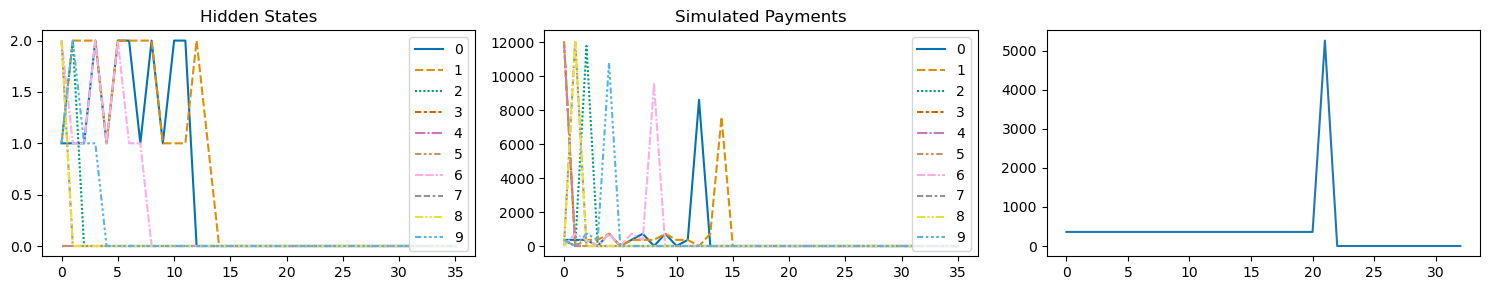

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

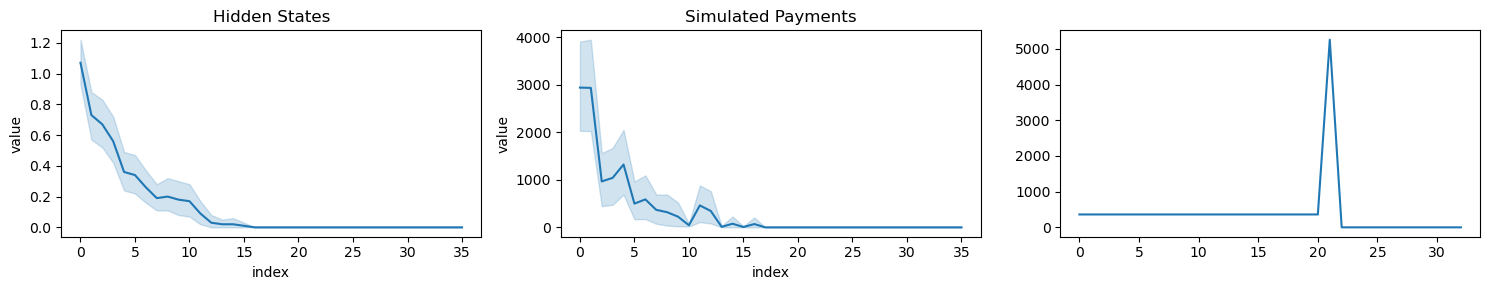

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [9]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment'], batch['loan_amnt'], batch['int_rate'], batch['pymnt']))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [12]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0        19651.014624
34       17918.808465
41       17720.385052
50       12537.891158
93       22900.669109
             ...     
99275    10148.833098
99373    22872.688970
99401    26301.395965
99612    20082.887680
99701    18122.700567
Length: 99866, dtype: float64

In [13]:
s_sim_pymnts.sum()

1508178628.4808939

# Score distributions

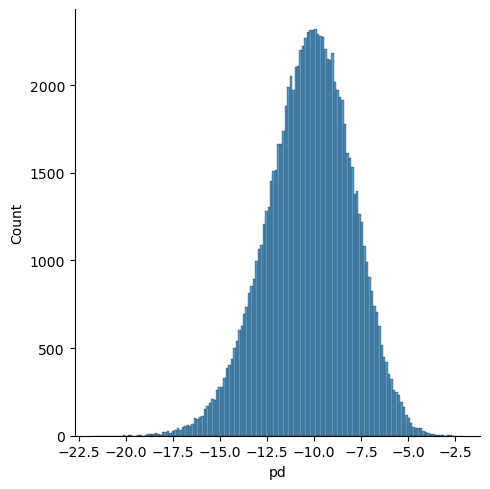

In [14]:
from scipy.special import logit

sns.displot(logit(df.pd), kind='hist')

In [15]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [16]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
pd_qcut,,
"(-0.000999999645, 1.59e-06]",1.081326e+08,1.364332e+08
"(1.59e-06, 4.59e-06]",1.088412e+08,1.373732e+08
"(4.59e-06, 9.57e-06]",1.085148e+08,1.378184e+08
"(9.57e-06, 1.74e-05]",1.094403e+08,1.378170e+08
"(1.74e-05, 2.98e-05]",1.085103e+08,1.378331e+08
"(2.98e-05, 4.98e-05]",1.070357e+08,1.361429e+08
"(4.98e-05, 8.39e-05]",1.086613e+08,1.374624e+08
"(8.39e-05, 0.000147]",1.085646e+08,1.367060e+08
"(0.000147, 0.000278]",1.079031e+08,1.374420e+08


In [17]:
testpds = pd.read_csv('testpds.csv')
testpds = testpds.set_index('0')['1'].rename('testpd')
testpds.sort_index()

0
0        2.355086e-06
1        1.794765e-08
2        8.374893e-09
3        6.119470e-06
4        9.059268e-08
             ...     
99861    2.780588e-08
99862    1.991988e-08
99863    3.055326e-07
99864    5.458783e-09
99865    1.394956e-07
Name: testpd, Length: 99866, dtype: float64

In [18]:
df = df.join(testpds)

In [19]:
df['testpd_qcut'] = pd.qcut(df.testpd, q=11)
df.groupby('testpd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
testpd_qcut,,
"(-0.00099999999999994, 5.32e-10]",9.942039e+07,1.088809e+08
"(5.32e-10, 2.19e-09]",1.020201e+08,1.167311e+08
"(2.19e-09, 5.96e-09]",1.059447e+08,1.231604e+08
"(5.96e-09, 1.36e-08]",1.079623e+08,1.281207e+08
"(1.36e-08, 2.94e-08]",1.110932e+08,1.338713e+08
"(2.94e-08, 6.05e-08]",1.116178e+08,1.398542e+08
"(6.05e-08, 1.29e-07]",1.147037e+08,1.452121e+08
"(1.29e-07, 2.88e-07]",1.139454e+08,1.490951e+08
"(2.88e-07, 7.57e-07]",1.156806e+08,1.536006e+08


In [20]:
df.sort_values('testpd').head(10).pymnt

59969    [tensor(750.9700), tensor(750.9700), tensor(75...
91903    [tensor(534.2900), tensor(534.2900), tensor(53...
19458    [tensor(1169.7568), tensor(1169.7568), tensor(...
46798    [tensor(752.9794), tensor(752.9794), tensor(75...
63645    [tensor(480.1355), tensor(480.1355), tensor(48...
83189    [tensor(488.3728), tensor(488.3728), tensor(48...
3369     [tensor(732.9275), tensor(732.9275), tensor(73...
90804    [tensor(625.7200), tensor(625.7200), tensor(62...
61748    [tensor(268.5607), tensor(268.5607), tensor(26...
5294     [tensor(587.1900), tensor(587.1900), tensor(58...
Name: pymnt, dtype: object

In [21]:
df.sort_values('testpd').tail(10).pymnt

74128    [tensor(259.3767), tensor(259.3767), tensor(25...
24688    [tensor(221.5500), tensor(221.5500), tensor(22...
33184    [tensor(124.3320), tensor(124.3320), tensor(12...
10709    [tensor(218.3100), tensor(0.), tensor(0.), ten...
48505    [tensor(168.1100), tensor(168.1100), tensor(0....
7202     [tensor(139.8400), tensor(139.8400), tensor(13...
4294     [tensor(189.7525), tensor(189.7525), tensor(18...
74668    [tensor(139.3980), tensor(139.3980), tensor(13...
53178    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
49211    [tensor(149.7925), tensor(149.7925), tensor(14...
Name: pymnt, dtype: object

In [22]:
df['nopay'] = df.pymnt_sum < df.installment

<Axes: xlabel='pymnt_sum', ylabel='testpd'>

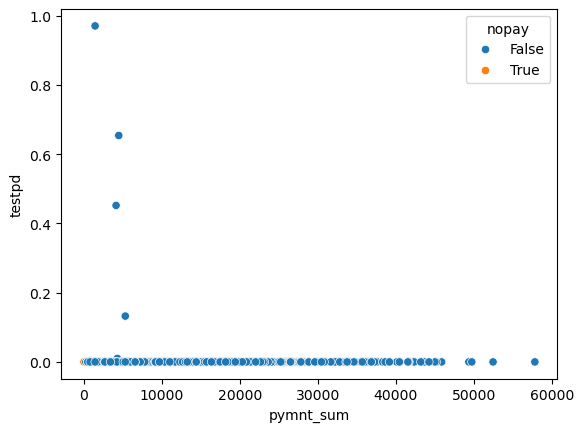

In [23]:
sns.scatterplot(df.sample(1_000), x='pymnt_sum', y='testpd', hue='nopay')

In [24]:
df.groupby('testpd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum', 'nopay']].sum()

,pymnt_sum,sim_pymnts_sum,nopay
testpd_qcut,,,
"(-0.00099999999999994, 5.32e-10]",9.942039e+07,1.088809e+08,9
"(5.32e-10, 2.19e-09]",1.020201e+08,1.167311e+08,14
"(2.19e-09, 5.96e-09]",1.059447e+08,1.231604e+08,15
"(5.96e-09, 1.36e-08]",1.079623e+08,1.281207e+08,14
"(1.36e-08, 2.94e-08]",1.110932e+08,1.338713e+08,20
"(2.94e-08, 6.05e-08]",1.116178e+08,1.398542e+08,24
"(6.05e-08, 1.29e-07]",1.147037e+08,1.452121e+08,20
"(1.29e-07, 2.88e-07]",1.139454e+08,1.490951e+08,21
"(2.88e-07, 7.57e-07]",1.156806e+08,1.536006e+08,21
